In [1]:
import crocoddyl
import numpy as np
import matplotlib.pyplot as plt 
import utils.unicycle as uni
from utils.plotting import plot_control_sequence, plot_state_trajectory, plot_cost, plot_convergence

from MPPI.mppi import MPPI, MPPILogger
from MPPI.mppi_ddp import MPPIDDP

In [2]:
# Fix random seed

np.random.seed(0)

## Defining the problem

Write states, u etc.

In [3]:
# crocoddyl.ActionModelCodeGen

In [4]:
# Defining model and cost weights
model = crocoddyl.ActionModelUnicycle()
data = model.createData()

# Cost function is defined here -> https://github.com/loco-3d/crocoddyl/blob/3cd866def6cbeb8d35a69cbbe5accc0ec5d0ca20/include/crocoddyl/core/actions/unicycle.hxx#L20
model.costWeights = np.array([
    1,   # state weight
    1,   # control weight
])

# Terminal state cost
model_term = crocoddyl.ActionModelUnicycle()
model_term.costWeights = np.array([100, 0])

# Defining problem
T  = 20
x0 = np.array([-1,-1,1])

## Solving the OCP with DDP

In [5]:
problem = crocoddyl.ShootingProblem(x0, [ model ] * T, model_term)
# problem.terminalModel = model_term

ddp = crocoddyl.SolverDDP(problem)
ddp.setCallbacks([crocoddyl.CallbackLogger(), crocoddyl.CallbackVerbose()])
ddp.solve()
print(f"Final DDP cost: {ddp.cost}")

Final DDP cost: 18.64170485948688
iter    cost       merit      stop      |grad|      preg       dreg      step   ||ffeas||  ||gfeas||  ||hfeas||   dV-exp       dV      dPhi-exp     dPhi
   0  1.029e+03  0.000e+00  0.000e+00  0.000e+00  1.000e-09  1.000e-09  1.0000  1.000e+00  0.000e+00  0.000e+00  0.000e+00 -1.029e+03  0.000e+00  0.000e+00
   1  1.949e+01  0.000e+00  1.010e+03  2.020e+03  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  1.010e+03  1.009e+03  0.000e+00  0.000e+00
   2  1.865e+01  0.000e+00  8.268e-01  1.654e+00  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  8.268e-01  8.431e-01  0.000e+00  0.000e+00
   3  1.864e+01  0.000e+00  9.073e-03  1.815e-02  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  9.073e-03  9.582e-03  0.000e+00  0.000e+00
   4  1.864e+01  0.000e+00  2.312e-04  4.624e-04  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  2.312e-04  2.534e-04  0.000e+00  0.000e+00
   5  1.864e+01  0.000e+00  1.283

In [6]:
ddp

In [7]:
log = ddp.getCallbacks()[0]
u_opt_ddp = np.array(log.us)
# plot_control_sequence(u_opt_ddp)

x_opt_ddp = np.array(log.xs)
ddp_costs = log.costs
# plot_state_trajectory(x_opt_ddp)

# plot_cost(log.costs)
# plot_convergence(log.costs)

In [8]:
# crocoddyl.plotConvergence(
#     log.costs,
#     log.pregs,
#     log.dregs,
#     log.grads,
#     log.stops,
#     log.steps,
#     figIndex=2,
#     show=False,
# )

## Solving the OCP with MPPI

In [9]:
# MPPI parameters
horizon = T         # Number of time steps in the prediction horizon
num_samples = 100    # Number of control samples
lambda_param = 10    # Temperature parameter
noise_std = np.array([0.1, 0.1]) # Std dev for [linear_vel_noise, angular_vel_noise]
n_iter = 30

# Logging
logger_mppi = MPPILogger(enable_logging=True, n_log=5)

# Initial state for the unicycle: [x, y, yaw]
x0 = np.array([-1,-1,1])


print("Running MPPI solver...")
mppi_solver = MPPI(model, model_term, horizon, num_samples, lambda_param, noise_std, param_exploration=0.0, n_filt=5, logger=logger_mppi)
u_opt_mppi = mppi_solver.solve(x0, num_iterations=n_iter)

print("\nRolling out trajectory with optimal controls...")
x_opt_mppi, mppi_final_cost = mppi_solver.rollout_trajectory(x0, u_opt_mppi)
# Store the final optimized nominal control sequence in the logger
logger_mppi.set_final_controls(u_opt_mppi)
logger_mppi.set_final_state(x_opt_mppi)

print(f"Final cost of optimal trajectory: {mppi_final_cost:.4f}")

Running MPPI solver...
Iteration 1/30, Min Cost: 13592.6226, Mean Cost: 15159.6220
Iteration 2/30, Min Cost: 11821.9643, Mean Cost: 13609.6308
Iteration 3/30, Min Cost: 9837.0778, Mean Cost: 11784.6593
Iteration 4/30, Min Cost: 8323.9018, Mean Cost: 9914.4993
Iteration 5/30, Min Cost: 6969.1613, Mean Cost: 8516.6469
Iteration 6/30, Min Cost: 5831.7225, Mean Cost: 7013.3303
Iteration 7/30, Min Cost: 4615.4305, Mean Cost: 5874.3138
Iteration 8/30, Min Cost: 3601.3760, Mean Cost: 4599.7830
Iteration 9/30, Min Cost: 2632.1609, Mean Cost: 3587.3290
Iteration 10/30, Min Cost: 2109.7151, Mean Cost: 2782.8173
Iteration 11/30, Min Cost: 1412.8616, Mean Cost: 2153.7566
Iteration 12/30, Min Cost: 936.0028, Mean Cost: 1449.4035
Iteration 13/30, Min Cost: 675.8837, Mean Cost: 941.5777
Iteration 14/30, Min Cost: 417.0586, Mean Cost: 702.6870
Iteration 15/30, Min Cost: 257.3664, Mean Cost: 439.1361
Iteration 16/30, Min Cost: 154.5334, Mean Cost: 286.0535
Iteration 17/30, Min Cost: 108.3209, Mean Cost

In [10]:
# # 3. Use the logger to plot the collected data
# print("\nPlotting results...")
# # logger.plot_total_cost()
# fig, axes = plt.subplots(3, 1)
# # Plot sampled controls for the first detailed log (actual MPPI iteration 0)
# # Showing nominal U for that iteration, and coloring by weight
# if logger.sampled_controls_hist:
#     pass
# #     print("\nPlotting sampled controls for Iteration 0 (with nominal U and weights)...")
# #     logger.plot_sampled_controls(iteration_index_in_log=0,
# #                                         num_samples_to_plot=20,
# #                                         plot_nominal_controls_for_this_iter=True,
# #                                         plot_final_nominal_controls=True,
# #                                         color_by_weight=True)

#     # Plot sampled states for the first detailed log (actual MPPI iteration 0)
#     print("\nPlotting sampled states for Iteration 0 (with nominal X)...")
#     logger.plot_sampled_states(iteration_index_in_log=0,
#                                     num_samples_to_plot=20,
#                                     plot_nominal_states_for_this_iter=True,
#                                     plot_final_nominal_states=True,
#                                     color_by_weight=True,
#                                     fig=fig, axes=axes)

# # Plot for a later detailed log (e.g., actual MPPI iteration 5, if it exists)

# if len(logger.sampled_controls_hist) > 1:
#     pass
#     # for i in range(1, len(logger.sampled_cost)):
#     #     print(f"\nPlotting sampled controls for Iteration {i} (with nominal U and weights)...")
#     #     logger.plot_sampled_controls(iteration_index_in_log=i, # This refers to the 2nd logged detailed iteration
#     #                                         num_samples_to_plot=100,
#     #                                         plot_nominal_controls_for_this_iter=True,
#     #                                         plot_final_nominal_controls=True,
#     #                                         color_by_weight=True)
#     print("\nPlotting sampled states for Iteration 5 (with nominal X)...")
#     for i in range(1, len(logger.sampled_cost)):
#         logger.plot_sampled_states(iteration_index_in_log=i,
#                                         num_samples_to_plot=100,
#                                         plot_nominal_states_for_this_iter=True,
#                                         plot_final_nominal_states=True,
#                                         color_by_weight=True)

In [11]:
# logger.plot_sampled_cost_histogram(iteration_index_in_log=2, bins=30)
# logger.plot_weights_histogram(iteration_index_in_log=1, bins=10)


## Plots

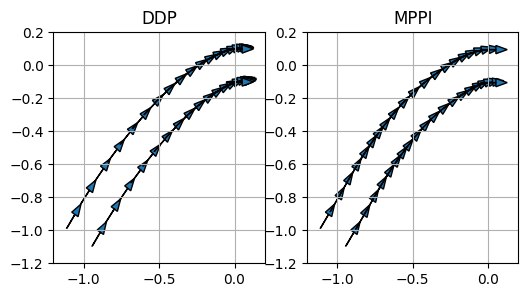

In [12]:
# plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
uni.plotUnicycleSolution(x_opt_ddp, axs[0])
uni.plotUnicycleSolution(x_opt_mppi, axs[1])

axs[0].set_title("DDP")
axs[1].set_title("MPPI")

for ax in axs:
    ax.set_xlim(-1.2, 0.2)
    ax.set_ylim(-1.2, 0.2)
    ax.grid()

# uni.plotUnicycleSolution(X_optimal, ax)
# ax.set_xlim([-1.5, 0.5])
# ax.set_ylim([-1.5, 0.5])
# ax.grid()

array([<Axes: title={'center': 'State Trajectory'}>, <Axes: >,
       <Axes: xlabel='Time Step (Horizon + 1)'>], dtype=object)

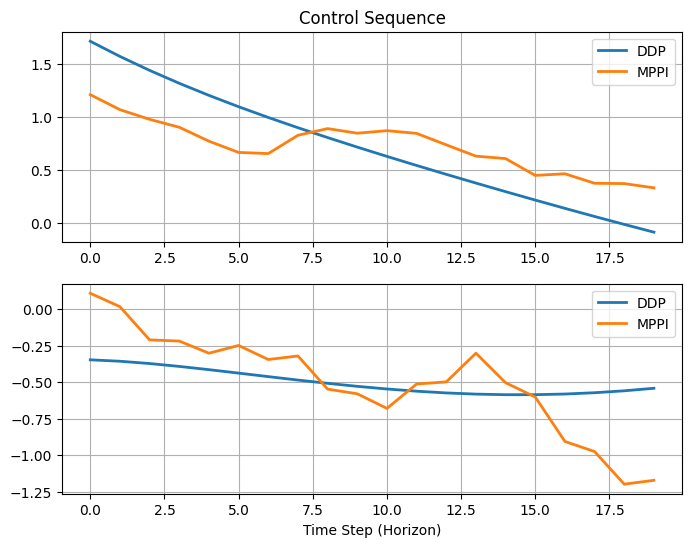

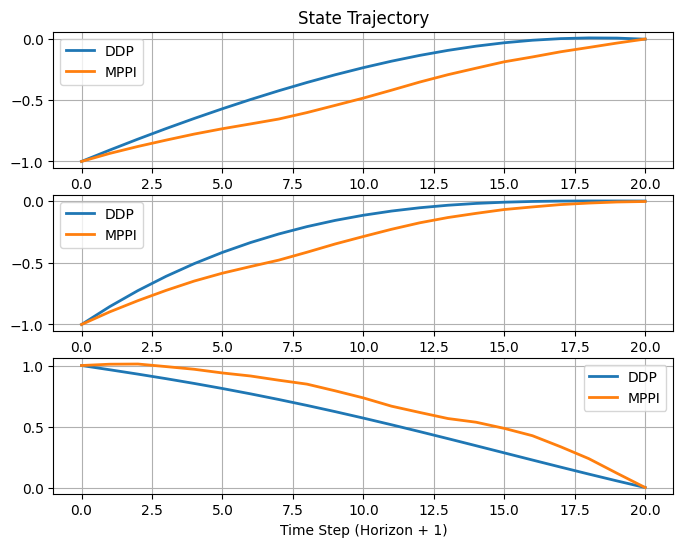

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))
plot_control_sequence(u_opt_ddp, axs, labels=["DDP"]*2)
plot_control_sequence(u_opt_mppi, axs, labels=["MPPI"]*2)

fig, axs = plt.subplots(3, 1, figsize=(8, 6))
plot_state_trajectory(x_opt_ddp, axs, labels=["DDP"]*3)
plot_state_trajectory(x_opt_mppi, axs, labels=["MPPI"]*3)

In [14]:
u_opt_ddp.shape

(20, 2)

## Solving OCP with MPPI-DDP

In [15]:
# MPPI parameters
horizon = T         # Number of time steps in the prediction horizon
num_samples = 100    # Number of control samples
lambda_param = 10    # Temperature parameter
noise_std = np.array([0.1, 0.1]) # Std dev for [linear_vel_noise, angular_vel_noise]
n_iter = 30

# Logging
logger_mppi_ddp = MPPILogger(enable_logging=True, n_log=5)

# Initial state for the unicycle: [x, y, yaw]
x0 = np.array([-1,-1,1])

print("Running MPPI-DDP solver...")
# FIX: Add 'problem' as the ddp_problem argument
mppi_ddp_solver = MPPIDDP(model, model_term, horizon, num_samples, lambda_param, noise_std,
                      ddp_problem=problem,
                      param_exploration=0.0, n_filt=5, logger=logger_mppi_ddp,
                      num_ddp_replace=1)
u_opt_mppi_ddp = mppi_ddp_solver.solve(x0, num_iterations=n_iter)

print("\nRolling out trajectory with optimal controls...")
x_opt_mppi_ddp, final_cost_mppi_ddp = mppi_ddp_solver.rollout_trajectory(x0, u_opt_mppi_ddp)
# Store the final optimized nominal control sequence in the logger
logger_mppi_ddp.set_final_controls(u_opt_mppi_ddp)
logger_mppi_ddp.set_final_state(x_opt_mppi_ddp)

print(f"Final cost of optimal trajectory: {final_cost_mppi_ddp:.4f}")

Running MPPI-DDP solver...
Iteration 1/30, Min Cost: 1202.9850, Mean Cost: 14911.3743, DDP Cost: 1202.9850, DDP converged: False
Iteration 2/30, Min Cost: 28.0514, Mean Cost: 1135.9252, DDP Cost: 28.0514, DDP converged: False
Iteration 3/30, Min Cost: 18.6998, Mean Cost: 65.5686, DDP Cost: 18.6998, DDP converged: False
Iteration 4/30, Min Cost: 18.6733, Mean Cost: 45.1816, DDP Cost: 18.6733, DDP converged: False
Iteration 5/30, Min Cost: 18.6644, Mean Cost: 44.0306, DDP Cost: 18.6644, DDP converged: False
Iteration 6/30, Min Cost: 17.8071, Mean Cost: 42.8850, DDP Cost: 18.6585, DDP converged: False
Iteration 7/30, Min Cost: 18.6602, Mean Cost: 41.5695, DDP Cost: 18.6602, DDP converged: False
Iteration 8/30, Min Cost: 18.3917, Mean Cost: 44.6652, DDP Cost: 18.6546, DDP converged: False
Iteration 9/30, Min Cost: 18.1638, Mean Cost: 39.9736, DDP Cost: 18.6522, DDP converged: False
Iteration 10/30, Min Cost: 18.1664, Mean Cost: 39.4471, DDP Cost: 18.6522, DDP converged: False
Iteration 11/

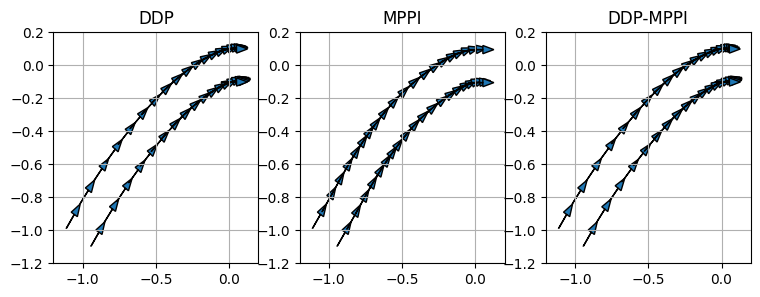

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3)) # Changed to 1 row, 3 columns, and adjusted figsize

uni.plotUnicycleSolution(x_opt_ddp, axs[0])
uni.plotUnicycleSolution(x_opt_mppi, axs[1])
uni.plotUnicycleSolution(x_opt_mppi_ddp, axs[2]) # Added the third plot for ddp-mppi

axs[0].set_title("DDP")
axs[1].set_title("MPPI")
axs[2].set_title("DDP-MPPI") # Added title for the third plot

for ax in axs:
    ax.set_xlim(-1.2, 0.2)
    ax.set_ylim(-1.2, 0.2)
    ax.grid()

array([<Axes: title={'center': 'State Trajectory'}>, <Axes: >,
       <Axes: xlabel='Time Step (Horizon + 1)'>], dtype=object)

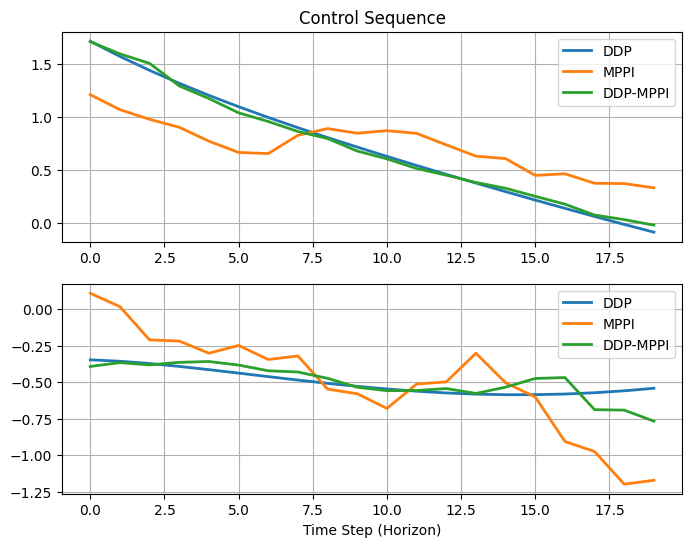

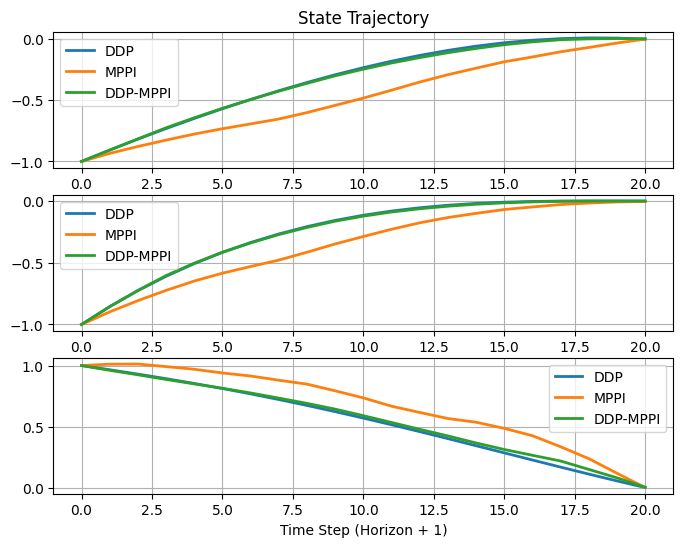

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))
plot_control_sequence(u_opt_ddp, axs, labels=["DDP"]*2)
plot_control_sequence(u_opt_mppi, axs, labels=["MPPI"]*2)
plot_control_sequence(u_opt_mppi_ddp, axs, labels=["DDP-MPPI"]*2) # Added DDP-MPPI control sequence

fig, axs = plt.subplots(3, 1, figsize=(8, 6))
plot_state_trajectory(x_opt_ddp, axs, labels=["DDP"]*3)
plot_state_trajectory(x_opt_mppi, axs, labels=["MPPI"]*3)
plot_state_trajectory(x_opt_mppi_ddp, axs, labels=["DDP-MPPI"]*3) # Added DDP-MPPI state trajectory

(10.0, 50.0)

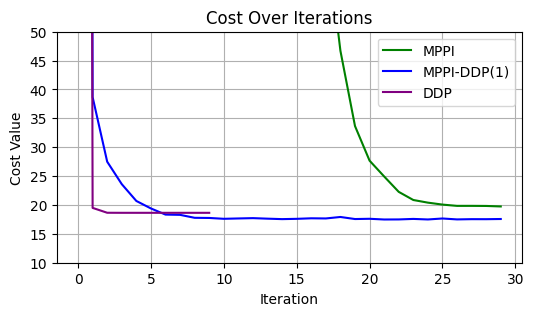

In [18]:
# Create a figure and a single subplot for the cost histories
fig, ax = plt.subplots(1, 1, figsize=(6, 3)) # [2]

# Plot each cost history on the same subplot
plot_cost(logger_mppi.total_cost_hist, ax=ax, color="green",  label="MPPI") 
plot_cost(logger_mppi_ddp.total_cost_hist, ax=ax, color="blue", label="MPPI-DDP(1)")
plot_cost(ddp_costs, ax=ax, color="purple", label="DDP")
ax.legend()
ax.set_ylim(10, 50)

(-100.0, 10.0)

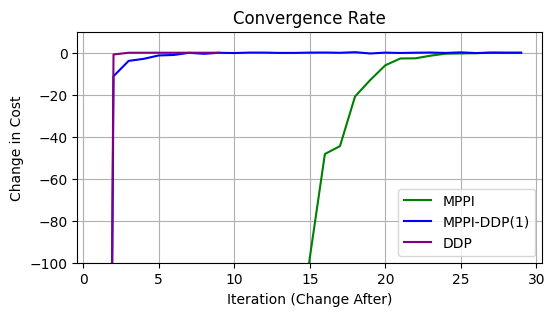

In [19]:
# Create a figure and a single subplot for the cost histories
fig, ax = plt.subplots(1, 1, figsize=(6, 3)) # [2]

# Plot each cost history on the same subplot
plot_convergence(logger_mppi.total_cost_hist, ax=ax, color="green",  label="MPPI") 
plot_convergence(logger_mppi_ddp.total_cost_hist, ax=ax, color="blue", label="MPPI-DDP(1)")
plot_convergence(ddp_costs, ax=ax, color="purple", label="DDP")
ax.legend()
ax.set_ylim(-100, 10)